In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# data paths
path_train = '/home/paul/workspace/postdoc-year1/projects/calprotectin/data/cleaned_train_val_test/train_set.csv'
path_val = '/home/paul/workspace/postdoc-year1/projects/calprotectin/data/cleaned_train_val_test/validation_set.csv'
path_test = '/home/paul/workspace/postdoc-year1/projects/calprotectin/data/cleaned_train_val_test/test_set.csv'


# loading 
train_df = pd.read_csv(path_train)
val_df = pd.read_csv(path_val)
test_df = pd.read_csv(path_test)

In [3]:
total_y = len(train_df) + len(val_df) + len(test_df)
positives = train_df['diagnosis_infection'].sum() + val_df['diagnosis_infection'].sum() + test_df['diagnosis_infection'].sum()
print(positives/total_y)

0.3135593220338983


In [4]:
# Separate features and labels
# FEATURES = ['crp_value_1', 'IL6_value_1']
# FEATURES = ['Cal_value_1']
FEATURES = ['crp_value_1', 'IL6_value_1', 'Cal_value_1']
TARGET = 'diagnosis_infection'

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_val = val_df[FEATURES]
y_val = val_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [5]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train)

# Transform the training, validation, and test data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Initialize the model
# We can add class_weight='balanced' to help with the imbalanced data
model = LogisticRegression(random_state=42, class_weight='balanced')

# Initialize the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training data
# We use 'roc_auc' as the score, as it's better for imbalanced classes than accuracy
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

print("\n--- Cross-Validation Results ---")
print(f"ROC AUC scores for each fold: {cv_scores}")
print(f"Mean ROC AUC: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of ROC AUC: {np.std(cv_scores):.4f}")



--- Cross-Validation Results ---
ROC AUC scores for each fold: [0.72934473 0.68660969 0.89031339 0.74561404 0.83408748]
Mean ROC AUC: 0.7772
Standard Deviation of ROC AUC: 0.0742


In [7]:
print("\n--- Final Model Training and Evaluation ---")

# Train the model on the ENTIRE scaled training set
model.fit(X_train_scaled, y_train)

# Evaluate on the unseen TEST set
y_pred_test = model.predict(X_test_scaled)
y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1] # Probabilities for the positive class

print("\nPerformance on the Test Set:")
print(f"Test Set ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))


--- Final Model Training and Evaluation ---

Performance on the Test Set:
Test Set ROC AUC Score: 0.8291

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        25
           1       0.75      0.55      0.63        11

    accuracy                           0.81        36
   macro avg       0.79      0.73      0.75        36
weighted avg       0.80      0.81      0.80        36



Confusion Matrix (Test Set):


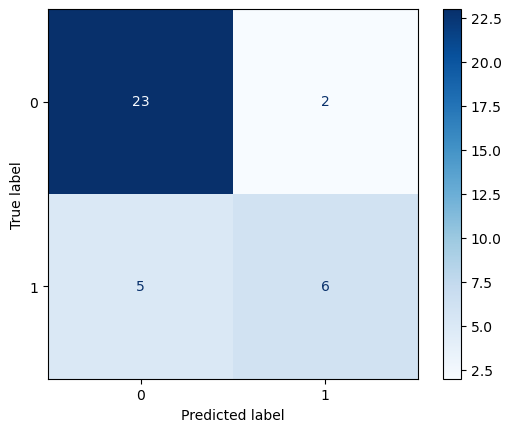

In [11]:
print("Confusion Matrix (Test Set):")
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
plt.show()

In [12]:
# # --- 6. Interpret Model Coefficients ---
# # The coefficients tell us the importance and direction of each feature
coefficients = pd.DataFrame(model.coef_[0], index=FEATURES, columns=['Coefficient'])
coefficients.sort_values('Coefficient', ascending=False, inplace=True)

print("\n--- Model Feature Importance ---")
print("Positive coefficients increase the log-odds of predicting sepsis (1).")
print("Negative coefficients decrease the log-odds.")
print(coefficients)


--- Model Feature Importance ---
Positive coefficients increase the log-odds of predicting sepsis (1).
Negative coefficients decrease the log-odds.
             Coefficient
IL6_value_1     3.380888
crp_value_1     0.697977
Cal_value_1     0.277411
